In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score
import matplotlib.pyplot as plt
import seaborn as sns
from fpdf import FPDF

In [2]:
customers = pd.read_csv("Customers.csv")
transactions = pd.read_csv("Transactions.csv")

In [3]:
data = pd.merge(transactions, customers, on="CustomerID")

In [4]:
customer_data = data.groupby("CustomerID").agg(
    total_spent=("TotalValue", "sum"),
    total_quantity=("Quantity", "sum"),
    avg_spent=("TotalValue", "mean"),
    transaction_count=("TransactionID", "count"),
).reset_index()

In [5]:
scaler = StandardScaler()
scaled_features = scaler.fit_transform(customer_data.iloc[:, 1:])

In [6]:
optimal_clusters = 0
best_db_index = float("inf")
cluster_range = range(2, 11)
db_index_scores = []

In [7]:
for n_clusters in cluster_range:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(scaled_features)
    db_index = davies_bouldin_score(scaled_features, cluster_labels)
    db_index_scores.append(db_index)
    if db_index < best_db_index:
        best_db_index = db_index
        optimal_clusters = n_clusters

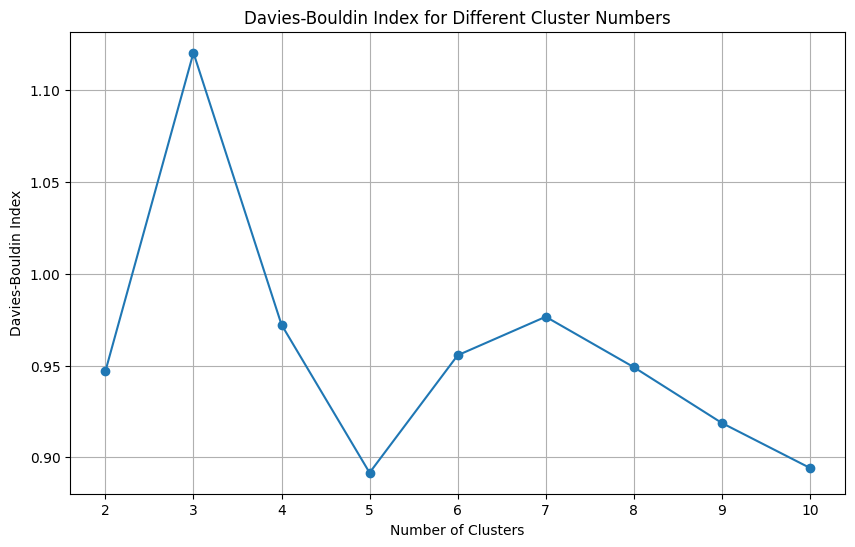

In [8]:
plt.figure(figsize=(10, 6))
plt.plot(cluster_range, db_index_scores, marker="o")
plt.title("Davies-Bouldin Index for Different Cluster Numbers")
plt.xlabel("Number of Clusters")
plt.ylabel("Davies-Bouldin Index")
plt.grid()
plt.show()

In [9]:
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42, n_init=10)
customer_data["Cluster"] = kmeans.fit_predict(scaled_features)

In [10]:
cluster_summary = customer_data.groupby("Cluster").agg(
    avg_spent=("total_spent", "mean"),
    total_spent=("total_spent", "sum"),
    total_quantity=("total_quantity", "sum"),
    total_customers=("CustomerID", "count"),
).reset_index()

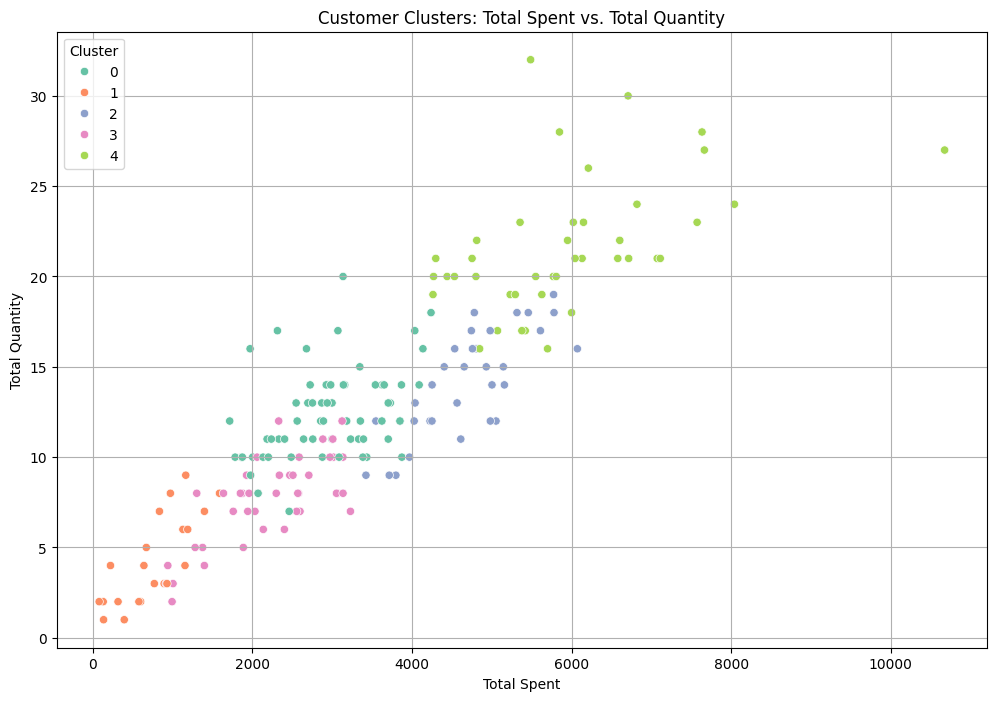

In [13]:
plt.figure(figsize=(12, 8))
sns.scatterplot(
    x=customer_data["total_spent"],
    y=customer_data["total_quantity"],
    hue=customer_data["Cluster"],
    palette="Set2",
)
plt.title("Customer Clusters: Total Spent vs. Total Quantity")
plt.xlabel("Total Spent")
plt.ylabel("Total Quantity")
plt.legend(title="Cluster")
plt.grid()
plt.show()

In [17]:
pdf = FPDF()
pdf.set_auto_page_break(auto=True, margin=15)
pdf.add_page()
pdf.set_font("Arial", size=12)

pdf.set_font("Arial", style="B", size=16)
pdf.cell(200, 10, txt="Customer Segmentation Report", ln=True, align="C")
pdf.ln(10)

pdf.set_font("Arial", size=12)
pdf.multi_cell(0, 10, txt=f"""
Customer Segmentation Results
-----------------------------
Optimal Number of Clusters: {optimal_clusters}
Best DB Index Value: {best_db_index:.2f}
""")

pdf.ln(5)
pdf.set_font("Arial", style="B", size=14)
pdf.cell(0, 10, txt="Cluster Summary:", ln=True)
pdf.set_font("Arial", size=12)


In [18]:
for index, row in cluster_summary.iterrows():
    cluster_details = f"""
    Cluster {row['Cluster']}:
    - Average Spending: {row['avg_spent']:.2f}
    - Total Spending: {row['total_spent']:.2f}
    - Total Quantity Purchased: {row['total_quantity']:.2f}
    - Total Customers: {row['total_customers']}
    """
    pdf.multi_cell(0, 10, txt=cluster_details)

In [19]:
pdf.output("Koushik_Akula_Clustering.pdf")
print("Clustering PDF report generated successfully.")

Clustering PDF report generated successfully.


In [20]:
customer_data.to_csv("FirstName_LastName_Clustering_Results.csv", index=False)